Using TensorFlow backend.


all_picked: 316
all_picked: 229


Instructions for updating:
Use keras.layers.AveragePooling2D instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.


Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNet_0526_01/epoch_2.ckpt


  0%|          | 0/545 [00:00<?, ?it/s]

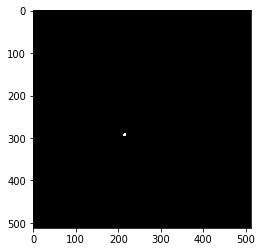

hi


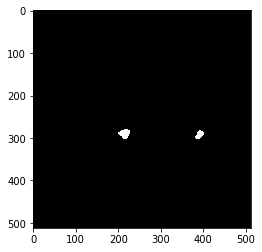

In [ ]:
%matplotlib inline
import argparse, logging, os, sys, time
import cv2, pickle, shutil
import matplotlib.pyplot as plt
import numpy as np
import SimpleITK as sitk
import tensorflow as tf
from collections import defaultdict
from os.path import join as pj
from tqdm import tqdm

# When the TF module is large enough create a seperate folder for it
# TODO: Change working directory to point to folder of this script
sys.path.insert(0, "../../..") 
# from fast.cf_mod.misc.data_tools import BaseDataset, paths_for_dataset
from fast.cf_mod.misc.data_tools import BaseDataset
from fast.cf_mod.misc.utils import get_infos
from fast.cf_mod.misc.my_metrics import dice_coef_pat
# TODO: unify the process of building models
from fw_dependent.tf.model.tf_layers import tf_model
from fw_neutral.utils.data_proc import paths_from_data, im_normalize, preprocess
from fw_neutral.utils.config import Config

def parse_args():
    parser = argparse.ArgumentParser(
        """
        You need to be careful with resuming while also changing the batch size 
        with this script since it would change how many steps to take to drop LR.
        
        "eval" mode: 
            "--model_file": Checkpoint file.
            "--testset_dir"
            "--pkl_dir": Output.
        """)
    parser.add_argument("mode", choices=["train", "eval"])
    parser.add_argument("gpu", help="Choose GPU.")
    parser.add_argument("config", help="Config file.")
    
    # Training mode related
    parser.add_argument("-o", "--output_dir",
        help="""You only need to provide a prefix which will be automatically be 
            complemented by time to keep things distincive easily. This will be ignored
            when resuming from a checkpoint.""",
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNET_")
    parser.add_argument("--train_dir", help="Training set directory.",
        # default="/rdfs/fast/home/sunyingge/data/COV_19/prced_0512/Train_0519/",
        default="/rdfs/fast/home/sunyingge/data/COV_19/prced_0512/Train_0526/",
        )
    parser.add_argument("--batch_size", type=int, default=32,
        help="Provided here to enable easy overwritting (not supported yet).")
    parser.add_argument("--resume", help="Checkpoint file to resume from.",
        )
    parser.add_argument("--max_to_keep", default=30, help="Max number of checkpoint files to keep.")
    parser.add_argument("--num_retry", default=60)
    parser.add_argument("--retry_waittime", default=120, help="In seconds.")
    parser.add_argument("--eval_while_train", action="store_true", default=True,
        help="""Need to provide "--testset_dir" for this.""")

    # Eval mode related
    parser.add_argument("--testset_dir", nargs='+',
        default=["/rdfs/fast/home/sunyingge/data/COV_19/0508/TestSet/0519/normal_pneu_datasets",
        "/rdfs/fast/home/sunyingge/data/COV_19/0508/TestSet/0519/covid_pneu_datasets"]
        )
    parser.add_argument("--model_file",
#         default="/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNET_0525_2051_19/epoch_9.ckpt"
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNet_0526_01/epoch_2.ckpt"
        )
    parser.add_argument("--pkl_dir",
#         default="/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNET_0525_2051_19/epoch_9_res.pkl",
        default="/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNet_0526_01/epoch_2_res.pkl"
        )
    parser.add_argument("--thickness_thres", default=3.0)

    parser.add_argument("--debug", action="store_true")

#     return parser.parse_args()
#     So that this works with jupyter
    return parser.parse_args(args=[
        "eval",
        "2",
        "/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNet_0526_01/cfg.json",
#         "/rdfs/fast/home/sunyingge/data/models/workdir_0522/SEResUNET_0525_2051_19/base.json",
    ])

def ini_training_set(args, cfg):
    print("==>>Training set: ")
    # _, train_pos, _ = paths_for_dataset(args.train_dir,
    #     flags=["train"],
    #     seed=999,
    #     isprint=True)
    train_paths  = paths_from_data(args.train_dir)
    np.random.seed(999)
    train_paths = np.random.permutation(train_paths).tolist()
    print("++"*30)
    print(f"Number of training samples: {len(train_paths)}")
    train_dataset = BaseDataset(train_paths, [], img_size=cfg.im_size, choice="all",
        image_key="im", mask_key="mask")
    print(f"train_dataset: {len(train_dataset)}")
    return train_dataset

def train(sess, args, cfg):
    train_dataset = ini_training_set(args, cfg)
    num_batches = len(train_dataset) // cfg.batch_size
    model = tf_model(args, cfg, num_batches)
    if args.resume:
        output_dir = os.path.dirname(args.resume)
    else:
        if os.path.exists(args.output_dir):
            output_dir = args.output_dir
        else:
            output_dir = args.output_dir + time.strftime("%m%d_%H%M_%S", time.localtime())
        if os.path.exists(output_dir):
            if not args.debug:
                input("The output directory already exists, please wait a moment and restart...")
                # print("The output directory already exists, please wait a moment and restart...")
                # sys.exit()
        else:
            os.makedirs(output_dir)
        if not os.path.exists(pj(output_dir, os.path.basename(args.config))):
            shutil.copy(args.config, output_dir)
    logging.basicConfig(level=logging.DEBUG,
        format="%(asctime)s %(message)s",
        datefmt="%m-%d %H:%M",
        filename=pj(output_dir, "training.log"),
        filemode="a")
    console = logging.StreamHandler()
    console.setLevel(logging.INFO)
    console.setFormatter(logging.Formatter("%(message)s"))
    logging.getLogger("").addHandler(console)
    saver = tf.train.Saver(max_to_keep=args.max_to_keep)
    num_para = np.sum([np.prod(v.get_shape().as_list()) for v in tf.trainable_variables()])
    logging.info("Total number of trainable parameters: {:.3}M.\n".format(float(num_para)/1e6))
    if args.resume:
        saver.restore(sess, args.resume)
        # This needs to be changed if the naming rule changes
        epoch = int((os.path.basename(args.resume).split('.')[0]).split('_')[-1])
    else:
        sess.run(tf.global_variables_initializer())
        epoch = 0
    while epoch < cfg.max_epoch:
        logging.info(f"Epoch {epoch + 1}\n")
        num_batches = 10 if args.debug else num_batches
        for i in range(num_batches):
            data_list = []
            for j in range(i * cfg.batch_size, (i + 1) * cfg.batch_size):
                im_ar, ann_ar = preprocess(train_dataset[j][0], train_dataset[j][1], cfg, True)
                data_list.append((im_ar, ann_ar))
                plt.imshow(ann_ar[:,:,0], cmap='gray')
                plt.savefig('test02.jpg')
                plt.imshow(im_ar[:,:,0], cmap='gray')
                plt.savefig('test03.jpg')
                input('as')
            data_ar = np.array(data_list)
            im_ar = data_ar[:,0,:,:,:]
            if cfg.num_class == 1:
                # to make it compatible with mutlicls label
                ann_ar = data_ar[:,1,:,:,:] > 0 
            elif cfg.loss == "softmax":
                ann_ar = data_ar[:,1,:,:,0]
            elif cfg.loss == "sigmoid":
                ann_ar = np.repeat(data_ar[:,1,:,:,:], cfg.num_class + 1, -1)
                all_cls_ids = np.ones(shape=ann_ar.shape)
                for i in range(cfg.num_class + 1):
                    all_cls_ids[...,i] = all_cls_ids[...,i] * i
                ann_ar = ann_ar == all_cls_ids
            ret_loss, ret_pred, _ = sess.run([model.loss, model.pred, model.optimizer],
                feed_dict={model.input_im: im_ar, model.input_ann: ann_ar,})
            # if i % 5 == 0:
            logging.info(f"Epoch progress: {i + 1} / {num_batches}, loss: {ret_loss}")
        for _ in range(args.num_retry):
            try:
                ckpt_dir = pj(output_dir, f"epoch_{epoch + 1}.ckpt")
                saver.save(sess, ckpt_dir)
                # a = np.random.uniform(size=1)#
                # if a[0] < 0.9:#
                #     raise Exception("Hi!")#
                break
            except:
                logging.warning("Failed to save checkpoint. Retry after 2 minutes...")
                time.sleep(args.retry_waittime)
                # time.sleep(10)#
        if args.eval_while_train:
            evaluation(sess, args, cfg, model, ckpt_dir.replace(".ckpt", "_res.pkl"), log=True)
        epoch += 1

def show_dice(all_res, log=False):
    stats = defaultdict(list)
    for res in all_res:
        if 'covid_pneu_datasets' in res[0]:
            if res[2] >= args.thickness_thres:
                stats['covid'].append(res[1])
                stats['thick'].append(res[1])
                stats['covid_thick'].append(res[1])
            elif res[2] < args.thickness_thres:
                stats['covid'].append(res[1])
                stats['thin'].append(res[1])
                stats['covid_thin'].append(res[1])
        elif 'normal_pneu_datasets' in res[0]:
            if res[2] >= args.thickness_thres:
                stats['normal'].append(res[1])
                stats['thick'].append(res[1])
                stats['normal_thick'].append(res[1])
            elif res[2] < args.thickness_thres:
                stats['normal'].append(res[1])
                stats['thin'].append(res[1])
                stats['normal_thin'].append(res[1])
    for key in stats:
        if log:
            logging.info(f"{key}: {np.mean(np.array(stats[key]))}")
        else:
            print(f"{key}: {np.mean(np.array(stats[key]))}")

def evaluation(sess, args, cfg, model=None, pkl_dir=None, log=False):
    """
        Args:
            model: For eval during training.
    """
    info_paths = []
    for folder in args.testset_dir:
        info_paths += get_infos(folder)
    info_paths = sorted(info_paths, key=lambda info:info[0])
    all_result = []
    if not model:
        model = tf_model(args, cfg)
        saver = tf.train.Saver()
        saver.restore(sess, args.model_file)
    else:
        args.pkl_dir = pkl_dir
    pbar = tqdm(total=len(info_paths))
#     if os.path.exists(args.pkl_dir):
#         input("Result file already exists. Press enter to \
#             continue and overwrite it when inference is done...")
    for num, info in enumerate(info_paths):
        img_file, lab_file = info[0:2]
        try:
            img_ori,  lab_ori  = sitk.ReadImage(img_file, sitk.sitkFloat32), sitk.ReadImage(lab_file, sitk.sitkInt16)
            img_arr,  lab_arr  = sitk.GetArrayFromImage(img_ori), sitk.GetArrayFromImage(lab_ori)
            # This converts all positive pixels to 1 regardless of their exact class
            lab_arr  = np.asarray(lab_arr > 0, dtype=np.uint8)
        except:
            continue
        depth, ori_shape = img_arr.shape[0], img_arr.shape[1:]
        spacing = img_ori.GetSpacing()
        dis_arr = im_normalize(img_arr, cfg.eval["ct_interval"][0], cfg.eval["ct_interval"][1], 
            cfg.eval["norm_by_interval"])
        # dis_arr = resize3d(dis_arr, cfg.im_size, interpolation=cv2.INTER_LINEAR)
        im_stack = []
        topleft_list = [] if cfg.preprocess["cropping"] else None
        for i in range(dis_arr.shape[0]):
            res = preprocess(dis_arr[i,...], None, cfg, False)
#             plt.imshow(res[:,:,-1], cmap='gray')
#             plt.imshow(res[1][:,:,-1], cmap='gray')
#             plt.savefig('test.jpg')
#             input('hi')
            if cfg.preprocess["cropping"]:
                im_stack.append(res[0])
                topleft_list.append(res[1])
            elif cfg.preprocess["resize"]:
                im_stack.append(res)
        dis_arr = np.array(im_stack)
        
        pred_ = []
        segs = cfg.batch_size
        assert isinstance(segs, int) and (segs>0) & (segs<70), "Please" 
        step = depth//segs + 1 if depth%segs != 0 else depth//segs
        for ii in range(step):
            if ii != step-1:
                pp = sess.run(model.pred, feed_dict={model.input_im: dis_arr[ii*segs:(ii+1)*segs, ...]}) #[0]
            else:
                pp = sess.run(model.pred, feed_dict={model.input_im: dis_arr[ii*segs:, ...]}) #[0]
            pp = 1/ (1 + np.exp(-pp)) # this only works for single class
            pred_.append(pp)
        dis_prd = np.concatenate(pred_, axis=0)
        # add the og version in
        if cfg.num_class == 1:
            dis_prd = dis_prd > 0.5
        else:
            if "normal_pneu" in img_file:
                cls_id = 2
            elif "covid_pneu" in img_file:
                cls_id = 1
            dis_prd = np.argmax(dis_prd, -1) == cls_id
#         print(dis_prd.shape)
#         for i in range(dis_prd.shape[0]):
#             print(np.sum(dis_prd[i,:,:,0]))
        # dis_prd = resize3d(dis_prd.astype(np.uint8), ori_shape, interpolation=cv2.INTER_NEAREST)
        # insert postprocessing here
        # dis_prd = np.array([postprocess(dis_prd[i,...], cfg, topleft_list) for i in range(dis_prd.shape[0])])
        pred_stack = []
        for i in range(dis_prd.shape[0]):
            if cfg.preprocess["cropping"]:
                padded_res = np.zeros(shape=ori_shape[::-1])
                padded_res[topleft_list[i][1]:topleft_list[i][1] + cfg.im_size[0],topleft_list[i][0]:topleft_list[i][0] + cfg.im_size[1]] = dis_prd[i,:,:,0]
                if np.sum(padded_res):
                    plt.imshow(padded_res, cmap='gray')
#                     plt.savefig('test01.jpg')
                    plt.show()
                    input('hi')
                pred_stack.append(padded_res)
            elif cfg.preprocess["resize"]:
                resized_res = cv2.resize(dis_prd[i,...].astype(np.float32), ori_shape[::-1], interpolation=cv2.INTER_NEAREST)
                pred_stack.append(resized_res)
#                 plt.imshow(resized_res, cmap='gray')
# #                 plt.show()
#                 plt.savefig('test01.jpg')
#                 input('hi')
        dis_prd = np.array(pred_stack)
        score = dice_coef_pat(dis_prd, lab_arr)
        if score < 0.3:
            if log:
                logging.info(os.path.dirname(lab_file))
                logging.info(score)
            else:
                print(os.path.dirname(lab_file))
                print(score)
        all_result.append([img_file, score, round(spacing[-1], 1)])
        pbar.update(1)
    pbar.close()
    pickle.dump(all_result, open(args.pkl_dir, "bw"))
    show_dice(all_result, log=log)

if __name__ == "__main__":
    args = parse_args()
    os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
    cfg = Config()
    cfg.load_from_json(args.config)
    config = tf.ConfigProto(allow_soft_placement=True)
    config.gpu_options.allow_growth = True
    config.gpu_options.per_process_gpu_memory_fraction = 0.95
    sess = tf.Session(config=config)

    if args.mode == "train":
        train(sess, args, cfg)
    elif args.mode == "eval":
        evaluation(sess, args, cfg)